In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import random
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#Select 5 Companies of each Sector as they tend to have different behaviorss
sp500 = pd.read_csv('../CSV/List_SP500_Wiki.csv')

# Define the number of random rows to select for each category
num_rows = 5

# Get unique categories in the 'GICS Sector' column
categories = sp500['GICS Sector'].unique()

# Initialize an empty DataFrame to store the selected rows
selected_rows = pd.DataFrame()

# Select random rows for each category
for category in categories:
    category_rows = sp500[sp500['GICS Sector'] == category]
    random_rows = category_rows.sample(n=min(num_rows, len(category_rows)), random_state=40)
    selected_rows = pd.concat([selected_rows, random_rows])

symbols = selected_rows['Symbol']

tickers = " ".join(symbols)

In [3]:
# Load Oil Prices
oil = yf.download('CL=F', start='2010-01-01', end='2023-05-22')
oil = oil.reset_index()
oil = oil[['Date', 'Adj Close']]
oil.rename(columns={'Adj Close' : 'Oil price'}, inplace=True)
print(oil.tail())

# Load Gold Prices
gold = yf.download('GC=F', start='2010-01-01', end='2023-05-22')
gold = gold.reset_index()
gold = gold[['Date', 'Adj Close']]
gold.rename(columns={'Adj Close' : 'Gold price'}, inplace=True)
print(gold.tail())
merged_oil_gold = oil.merge(gold, on='Date', how='inner')
merged_oil_gold.tail()


[*********************100%***********************]  1 of 1 completed
           Date  Oil price
3364 2023-05-15  71.110001
3365 2023-05-16  70.860001
3366 2023-05-17  72.830002
3367 2023-05-18  71.860001
3368 2023-05-19  71.550003
[*********************100%***********************]  1 of 1 completed
           Date   Gold price
3362 2023-05-15  2018.000000
3363 2023-05-16  1988.400024
3364 2023-05-17  1980.699951
3365 2023-05-18  1956.500000
3366 2023-05-19  1978.699951


,Date,Oil price,Gold price
3362,2023-05-15,71.110001,2018.000000
3363,2023-05-16,70.860001,1988.400024
3364,2023-05-17,72.830002,1980.699951
3365,2023-05-18,71.860001,1956.500000
3366,2023-05-19,71.550003,1978.699951


In [4]:
import matplotlib.pyplot as plt

def plot_time_series(df, date_column, column_name):
    # Convert the 'date_column' to datetime if it's not already
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Sort the DataFrame by date
    df = df.sort_values(by=date_column)

    # Get all the unique symbols
    symbols = df['Symbol'].unique()

    plt.figure(figsize=(12, 6))

    for symbol in symbols:
        symbol_df = df[df['Symbol'] == symbol]
        plt.plot(symbol_df[date_column], symbol_df[column_name], label=symbol)

    plt.title(f'Time Series Plot of {column_name} for all symbols', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(column_name, fontsize=14)
    plt.grid(True)
    plt.show()

def plot_log_diff(df, value_column):
    # Normalize the values
    scaler = MinMaxScaler()
    df[value_column] = scaler.fit_transform(df[value_column].values.reshape(-1, 1))
    
    # Calculate log differences
    df['Log Diff'] = np.log(df[value_column]) - np.log(df[value_column].shift(1))
    df = df.dropna()  # drop NaN values
    
    # Plot the log differences
    plt.figure(figsize=(12, 6))
    plt.plot(df['Log Diff'])
    plt.title('Log Differences of Normalized Values', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Log Differences', fontsize=14)
    plt.grid(True)
    plt.show()


In [6]:
random.seed(40)

tickers = pd.read_csv('../CSV/S&P500_opincome.csv')
tickers = [i for i in tickers['Symbol']]

tickers = random.sample(tickers, 5)
tickers = " ".join(tickers)

In [25]:
tickers

'FAST ODFL IEX TXT NSC BAX ABT ABC MDT IDXX ANSS ACN APH NTAP KLAC WBD OMC LYV NWSA CHTR MKC KR WBA MDLZ BF.B ETSY VFC HD LVS YUM AEE ES NEE ETR EVRG MKTX AFL SYF NDAQ FDS AMCR LIN MOS IFF IP AVB IRM PLD HST INVH WMB PSX HES OXY CTRA'

In [5]:
ticker_data = yf.download(tickers, start='2020-01-01', end='2023-05-22')
df = ticker_data.reset_index()

[*********************100%***********************]  55 of 55 completed

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


In [6]:
df_prices = ticker_data['Adj Close'].reset_index()
df_prices = df_prices.melt(id_vars='Date', var_name='Symbol', value_name='Adj Close')

df_volume = ticker_data['Volume'].reset_index()
df_volume = df_volume.melt(id_vars='Date', var_name='Symbol', value_name='Volume')

df= df_prices.merge(df_volume, on=['Date', 'Symbol'], how='left')
df = df[['Date', 'Symbol', 'Adj Close', 'Volume']]
df['Symbol'] =df['Symbol'].astype(str)

In [9]:
# Use if single ticker
df = ticker_data.reset_index()

In [7]:
# Merge Oil and Gold Data with Ticker information
df = df.merge(merged_oil_gold, on='Date', how='left')

start_date = df['Date'].min()

# Convert each date into the number of days since the start date
df['Time'] = (df['Date'] - start_date).dt.days

In [8]:
df

,Date,Symbol,Adj Close,Volume,Oil price,Gold price,Time
0,2020-01-02,ABC,80.829399,817600.0,61.180000,1524.500000,0
1,2020-01-03,ABC,79.812859,801500.0,63.049999,1549.199951,1
2,2020-01-06,ABC,80.981407,765000.0,63.270000,1566.199951,4
3,2020-01-07,ABC,80.401863,845300.0,62.700001,1571.800049,5
4,2020-01-08,ABC,81.180901,1182000.0,59.610001,1557.400024,6
...,...,...,...,...,...,...,...
46855,2023-05-15,YUM,137.140076,896200.0,71.110001,2018.000000,1229
46856,2023-05-16,YUM,138.135422,1572200.0,70.860001,1988.400024,1230
46857,2023-05-17,YUM,136.582672,1690400.0,72.830002,1980.699951,1231
46858,2023-05-18,YUM,137.806961,1435400.0,71.860001,1956.500000,1232


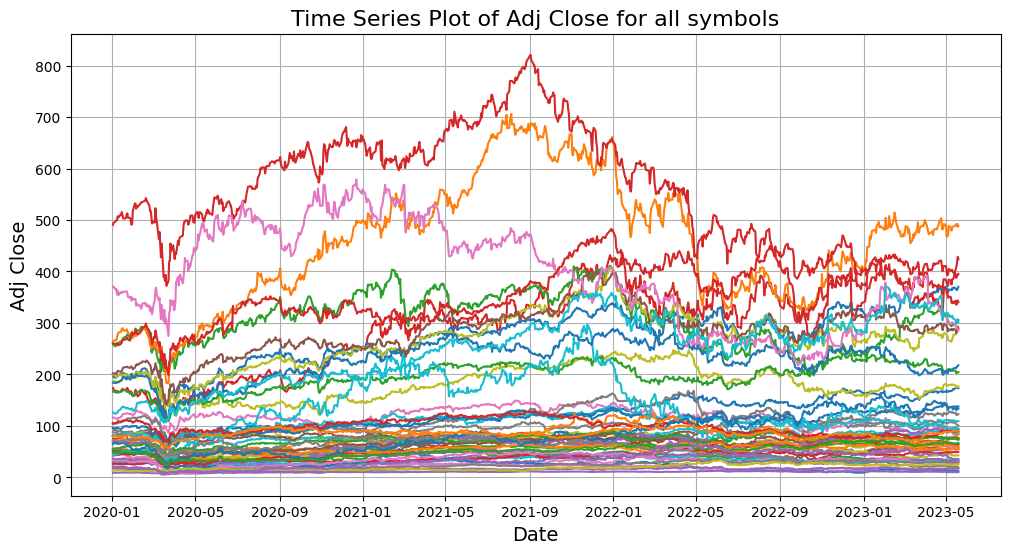

In [9]:
plot_time_series(df, 'Date', 'Adj Close')

In [11]:
import numpy as np
import torch
import math
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

def preprocess_data(df, window_size):
    sequences = []
    target = []

    # Create Log Returns
    df.loc[:, 'Log Return'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))

    # Scale the Log Return values
    scaler_log_return = StandardScaler()
    df.loc[1:, 'Log Return'] = scaler_log_return.fit_transform(df['Log Return'].values.reshape(-1, 1)[1:])

    # Scale the Volume values
    scaler_volume = StandardScaler()
    df.loc[:, 'Volume'] = scaler_volume.fit_transform(df['Volume'].values.reshape(-1, 1))

    # Scale the Oil price values
    scaler_oil_price = StandardScaler()
    df.loc[:, 'Oil price'] = scaler_oil_price.fit_transform(df['Oil price'].values.reshape(-1, 1))

    # Scale the Gold price values
    scaler_gold_price = StandardScaler()
    df.loc[:, 'Gold price'] = scaler_gold_price.fit_transform(df['Gold price'].values.reshape(-1, 1))

    # Remove rows with NaN values
    df = df.iloc[1:]

    # Create sequences
    for symbol in df['Symbol'].unique():
        symbol_df = df[df['Symbol'] == symbol].copy()
        for i in range(len(symbol_df) - window_size):
            sequence = symbol_df[['Log Return', 'Volume', 'Oil price', 'Gold price', 'Time']].iloc[i: i + window_size].values
            sequences.append(sequence)  # Append to the sequences list
            if i + window_size < len(symbol_df):  # Make sure we don't go out of bounds
                target.append(symbol_df['Log Return'].iloc[i + window_size])

    # Convert sequences and target to numpy arrays
    sequences = np.array(sequences)
    target = np.array(target)

    # Remove sequences with NaN values
    nan_sequence_mask = np.isnan(sequences).any(axis=(1, 2))
    sequences = sequences[~nan_sequence_mask]
    target = target[~nan_sequence_mask]

    return sequences, target, (scaler_log_return, scaler_volume, scaler_oil_price, scaler_gold_price)

def create_dataloader(sequences, target, batch_size):
    # Convert to PyTorch tensors
    sequences_tensor = torch.tensor(sequences).float()
    target_tensor = torch.tensor(target).float()

    # Create dataset and dataloader
    dataset = TensorDataset(sequences_tensor, target_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def t2v(tau, f, out_features, w, b, w0, b0):
    # Apply sinusoidal transformation with learnable parameters
    v1 = f(torch.matmul(tau, w) + b)
    # Apply linear transformation with learnable parameters
    v2 = torch.matmul(tau, w0) + b0
    # Concatenate the results
    return torch.cat([v1, v2], -1)

class Time2Vec(nn.Module):
    def __init__(self, in_features, out_features):
        super(Time2Vec, self).__init__()
        self.out_features = out_features
        
        # Learnable parameters for the sinusoidal transformation
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))

        # Learnable parameters for the linear transformation
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        # Sinusoidal activation function
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, nhid, nlayers, dropout=.1):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.time2vec = Time2Vec(1, 2)  # Add Time2Vec layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim+1, d_model),
            nn.LayerNorm(d_model)  # Add Layer Normalization
            )
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 524),
            nn.LayerNorm(524),
            nn.ReLU(),
            nn.Linear(524, 100),
            nn.ReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1)
        )
        
        # Apply Xavier initialization
        nn.init.xavier_uniform_(self.input_layer[0].weight)
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)


    def forward(self, src):
        # Separate time feature
        time_feature = src[:, :, -1:]  # Assuming 'Time' is the last feature
        other_features = src[:, :, :-1]

        # Apply Time2Vec to time feature
        time_feature = self.time2vec(time_feature)

        # Concatenate Time2Vec output with other features
        src = torch.cat((other_features, time_feature), -1)

        src = self.input_layer(src)
        src = self.pos_encoder(src)
        src = self.transformer_encoder(src)

        # Apply Global Average Pooling 1D
        src = F.adaptive_avg_pool1d(src.permute(0, 2, 1), 1).view(src.size(0), -1)

        # Apply the fully connected network to the output of GAP layer
        output = self.fc(src)
        return output.squeeze()

def train_model(dataloader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0.

    for sequences, target in dataloader:
        sequences = sequences.to(device)
        target = target.to(device)
        
        # Change how the target tensor is reshaped
        target = target.reshape(-1)
        
        optimizer.zero_grad()
        output = model(sequences)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def save_model(model, path):
    torch.save(model.state_dict(), path)

# Hyperparameters
window_size = 60
batch_size = 150
n_epochs = 10

# Preprocess data
sequences, target, scaler = preprocess_data(df, window_size)

# Create dataloader
dataloader = create_dataloader(sequences, target, batch_size)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model, criterion, and optimizer
model = TransformerModel(d_model=500, input_dim=5, output_dim=1, nhead=10, nhid=1000, nlayers=16).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=.0001)

In [12]:
# Training loop
for epoch in range(n_epochs):
    loss = train_model(dataloader, model, criterion, optimizer, device)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss:.6f}")

# Save the trained model
save_model(model, 'trained_model.pth')

Epoch [1/10], Loss: 0.258060
Epoch [2/10], Loss: 0.191323
Epoch [3/10], Loss: 0.190644
Epoch [4/10], Loss: 0.189674
Epoch [5/10], Loss: 0.190141
Epoch [6/10], Loss: 0.189788
Epoch [7/10], Loss: 0.188878
Epoch [8/10], Loss: 0.189173
Epoch [9/10], Loss: 0.189561
Epoch [10/10], Loss: 0.189655


In [19]:
def plot_predictions(dataloader, model, scalers, original_df, n_samples=10):
    # Grab a batch of data from the dataloader
    sequences, target = next(iter(dataloader))

    # Select n_samples number of sequences and targets
    sequences = sequences[:n_samples]
    target = target[:n_samples]

    # Get the model's predictions
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        predictions = model(sequences.to(device))

    # Detach the predictions and target from the GPU and convert to numpy arrays
    predictions = predictions.cpu().numpy()
    target = target.numpy()

    # Apply the inverse transformations to the predictions and the target
    scaler_log_return = scalers[0]
    predictions_rescaled = scaler_log_return.inverse_transform(predictions.reshape(-1, 1))
    target_rescaled = scaler_log_return.inverse_transform(target.reshape(-1, 1))

    # Get the initial log price for each sequence (this is the log price at t-1 for each prediction)
    initial_log_prices = np.log(original_df['Adj Close'].iloc[window_size - 1: window_size - 1 + n_samples].values)

    # Add the initial log price to the cumulative sum of the log returns
    predictions_adj_close = np.exp(initial_log_prices + np.cumsum(predictions_rescaled, axis=0))
    target_adj_close = np.exp(initial_log_prices + np.cumsum(target_rescaled, axis=0))

    # Plot the real vs predicted Adj Close prices
    plt.figure(figsize=(10, 6))
    plt.plot(target_adj_close, label='Real')
    plt.plot(predictions_adj_close, label='Predicted')
    plt.title('Real vs Predicted Adj Close Prices')
    plt.legend()
    plt.show()


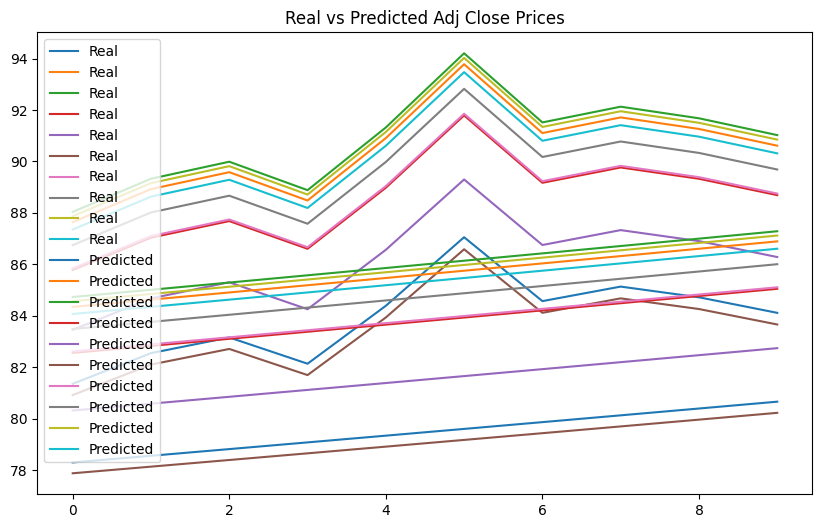

In [20]:
plot_predictions(dataloader, model, scaler, df)